<pre><font size=6>Spoken Digit Recognition</font></pre>

<pre>
In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>

</pre>

In [1]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Masking,Input,RepeatVector,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential , Model
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
##if you need any imports you can do that here. 

In [2]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

In [ ]:
#taken from old keras source code
def f1(y_true, y_pred_probabilities):
    y_pred=tf.argmax(y_pred_probabilities,1)
    y_pred=tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return (f1_val)/100

In [16]:
from sklearn.metrics import f1_score

def f1(y_true, y_pred):
  return f1_score(y_true, y_pred, average="micro")

def micro_f1(y_true, y_pred):
  y_pred=tf.math.argmax(y_pred, axis=1)
  return tf.py_function(f1,(y_true, y_pred),tf.double)

We shared recordings.zip, please unzip those. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"

Base_path="/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/"

all_files = [join(Base_path, f) for f in listdir(Base_path) if isfile(join(Base_path, f))]

In [ ]:
all_files[:10]

['/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/7_yweweler_2.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/8_nicolas_16.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/6_theo_22.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/9_theo_0.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/8_yweweler_30.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/7_jackson_42.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/8_jackson_10.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/9_jackson_42.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/4_jackson_30.wav',
 '/content/drive/My Drive/Colab Notebooks/Spoken/Recordings/6_jackson_21.wav']

<font size=4>Grader function 1 </font>

In [ ]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [ ]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0
column_names = ["path", "label"]

df_audio = pd.DataFrame(columns = column_names)
i=0
temp=len(Base_path)
for file_name in all_files:
  df_audio.loc[i] = [file_name] + [file_name[temp]]
  i+=1

In [ ]:
df_audio.head()

,path,label
0,/content/drive/My Drive/Colab Notebooks/Spoken...,7
1,/content/drive/My Drive/Colab Notebooks/Spoken...,8
2,/content/drive/My Drive/Colab Notebooks/Spoken...,6
3,/content/drive/My Drive/Colab Notebooks/Spoken...,9
4,/content/drive/My Drive/Colab Notebooks/Spoken...,8


In [ ]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB


<font size=4>Grader function 2 </font>

In [ ]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [ ]:

df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [ ]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%

X= df_audio.drop(['label'], axis = 1)
y= df_audio['label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=45,stratify=y)

y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

<font size=4>Grader function 3 </font>

In [ ]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [ ]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [ ]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
column_names = ["raw_data", "duration"]

X_train_processed = pd.DataFrame(columns = column_names)
X_test_processed = pd.DataFrame(columns = column_names)



In [ ]:

for i in range(len(X_train)):
  X_train_processed.loc[i] =load_wav(X_train.iloc[i,0])

X_train_processed.head()

,raw_data,duration
0,"[5.0387593e-05, 0.00015140238, 0.00021970968, ...",0.172653
1,"[0.00085550954, 0.00092619896, -3.6231086e-05,...",0.318776
2,"[0.00031743426, 0.0005046424, 0.00026486837, -...",0.292789
3,"[-0.008103399, -0.009011885, -0.0082764765, -0...",0.349751
4,"[0.008970253, 0.011066285, 0.011951065, 0.0123...",0.657415


In [ ]:
for i in range(len(X_test)):
  X_test_processed.loc[i] =load_wav(X_test.iloc[i,0])

X_test_processed.head()

,raw_data,duration
0,"[0.0003232073, -5.0014445e-05, -0.00021603802,...",0.314875
1,"[0.00082664215, -0.0017093286, -0.0058821477, ...",0.361270
2,"[-3.548877e-05, 1.0697427e-05, 2.5139254e-05, ...",0.309887
3,"[1.480199e-05, 0.00010912882, 0.00018360981, 0...",0.181270
4,"[0.011016414, 0.013351645, 0.013998778, 0.0138...",0.537506


In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_processed, y_train),open('/content/drive/My Drive/Colab Notebooks/Spoken/train_data.pkl','wb'))
pickle.dump((X_test, X_test_processed,y_test),open('/content/drive/My Drive/Colab Notebooks/Spoken/test_data.pkl','wb'))

In [4]:
X_train, X_train_processed, y_train = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Spoken/train_data.pkl', 'rb')) 
X_test, X_test_processed,y_test = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Spoken/test_data.pkl', 'rb')) 

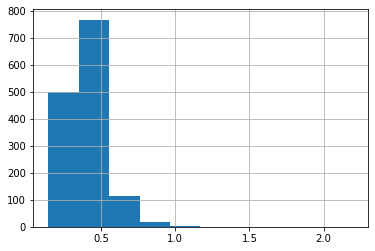

In [ ]:
X_train_processed['duration'].hist()

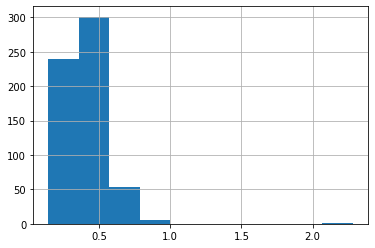

In [ ]:
X_test_processed['duration'].hist()

[]

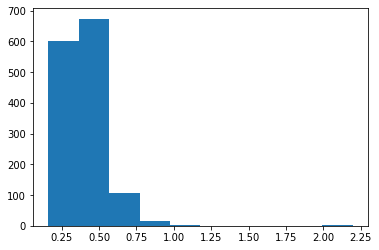

In [ ]:
#plot the histogram of the duration for trian


(array([224., 320.,  50.,   5.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.14353741, 0.35746032, 0.57138322, 0.78530612, 0.99922902,
        1.21315193, 1.42707483, 1.64099773, 1.85492063, 2.06884354,
        2.28276644]),
 <a list of 10 Patch objects>)

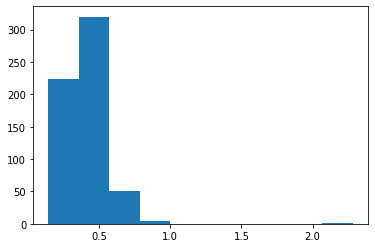

In [ ]:
#plot the histogram of the duration for trian


In [ ]:
#print 0 to 100 percentile values with step size of 10 for train data duration.
duration =X_train_processed['duration']

for i in range(0,101,10):
  print("{}th percentile is {}".format(i,np.percentile(duration, i)))


0th percentile is 0.1436281179138322
10th percentile is 0.26225396825396824
20th percentile is 0.300172335600907
30th percentile is 0.33207256235827665
40th percentile is 0.3595827664399093
50th percentile is 0.39090702947845807
60th percentile is 0.41941043083900226
70th percentile is 0.4493378684807256
80th percentile is 0.48381859410430844
90th percentile is 0.5528934240362812
100th percentile is 2.195918367346939


In [ ]:
 ##print 90 to 100 percentile values with step size of 1. 
 duration =X_train_processed['duration']

for i in range(90,101,1):
  print("{}th percentile is {}".format(i,np.percentile(duration, i)))


90th percentile is 0.5528934240362812
91th percentile is 0.5619170068027212
92th percentile is 0.5778757369614514
93th percentile is 0.5941251700680278
94th percentile is 0.6091065759637188
95th percentile is 0.6240793650793651
96th percentile is 0.6401215419501133
97th percentile is 0.6611179138321994
98th percentile is 0.6884154195011338
99th percentile is 0.7963859410430838
100th percentile is 2.195918367346939


<font size=4>Grader function 4 </font>

In [ ]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [5]:
max_length  = 17640

In [ ]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask

## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

In [6]:
def convert_toSequence(sampleData):

    raw_data=sampleData
    
    mask = []

    if len(raw_data) > max_length:
      raw_data = raw_data[0 : max_length]

    temp=len(raw_data)
    if len(raw_data) < max_length:
      seq = [0] * (max_length-len(raw_data))
      raw_data=np.append(raw_data, seq)


    mask=[True]*temp+[False]*(max_length-temp)

    
    #print(len(raw_data),len(mask))
    return raw_data, mask

In [7]:
def convert_dateset(audioFiles):

  pad_seq, masks = [], []
  #temp=audioFiles.head(15)
  for index, audio in audioFiles.iterrows():

    sample, mask = convert_toSequence(audio['raw_data'])
    pad_seq.append(sample)
    masks.append(mask)

  return (
        np.array(pad_seq),
        np.array(masks)
    )


In [8]:
#all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.
(X_train_pad_seq, X_train_mask) =  convert_dateset(X_train_processed)
(X_test_pad_seq, X_test_mask) =  convert_dateset(X_test_processed)

In [9]:
X_train_processed.head(15)

,raw_data,duration
0,"[5.0387593e-05, 0.00015140238, 0.00021970968, ...",0.172653
1,"[0.00085550954, 0.00092619896, -3.6231086e-05,...",0.318776
2,"[0.00031743426, 0.0005046424, 0.00026486837, -...",0.292789
3,"[-0.008103399, -0.009011885, -0.0082764765, -0...",0.349751
4,"[0.008970253, 0.011066285, 0.011951065, 0.0123...",0.657415
5,"[1.4945291e-05, -8.44925e-06, -5.7357425e-05, ...",0.332517
6,"[-0.00013766013, -6.854847e-05, 2.6776732e-05,...",0.350023
7,"[0.0020966087, -0.0004210327, -0.0060296142, -...",0.231293
8,"[-7.541328e-06, -4.167249e-05, -6.0260005e-05,...",0.314785
9,"[-0.0073072845, -0.004234679, -0.0010168038, -...",0.355283


<font size=4>Grader function 5 </font>

In [ ]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### 1. Giving Raw data directly. 

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). 
3. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
4. make sure that it won't overfit. 
5. You are free to include any regularization
</pre>

In [17]:

input_layer1 = Input(shape=(17640,1),name = 'input_layer',dtype='float32')

input_layer2 = Input(shape=(17640,),name='input_mask',dtype='bool')

LSTM_layer = LSTM(50,return_sequences=False,name = 'LSTM_layer')(input_layer1,mask = input_layer2)

dense = Dense(32,activation='relu',name = 'dense')(LSTM_layer)

dense_1 = Dense(24,activation='relu',name = 'dense_1')(dense)

dense_2 = Dense(10, activation = 'softmax',name='dense_2')(dense_1)

#concat = concatenate([input_layer,input_mask])

model = Model([input_layer1, input_layer2],dense_2)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy',micro_f1])

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 17640)]      0                                            
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 50)           10400       input_layer[0][0]                
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           1632        LSTM_layer[0][0]      

In [19]:
import datetime
log_dir="/content/drive/My Drive/Colab Notebooks/Spoken/logs/Model1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [20]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [21]:
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [22]:
#train your model
model.fit([X_train_pad_seq,X_train_mask], y_train,   epochs=3, batch_size=64, callbacks=[tensorboard_callback])

Epoch 1/3
 1/22 [>.............................] - ETA: 0s - loss: 2.3025 - accuracy: 0.0781 - micro_f1: 0.0781WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
22/22 [==============================] - 298s 14s/step - loss: 2.3032 - accuracy: 0.0836 - micro_f1: 0.0832
Epoch 2/3
22/22 [==============================] - 280s 13s/step - loss: 2.3028 - accuracy: 0.0879 - micro_f1: 0.0879
Epoch 3/3
22/22 [==============================] - 283s 13s/step - loss: 2.3028 - accuracy: 0.0993 - micro_f1: 0.0994


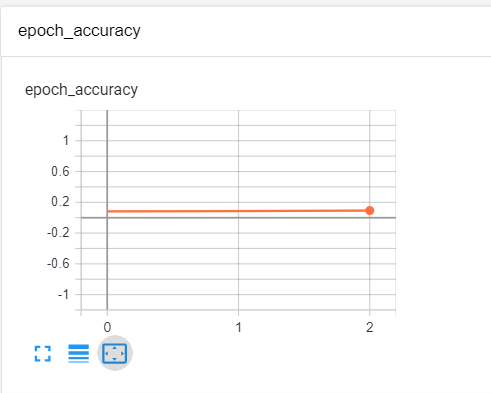

In [1]:
from PIL import Image
Image.open("model_1_1.png")

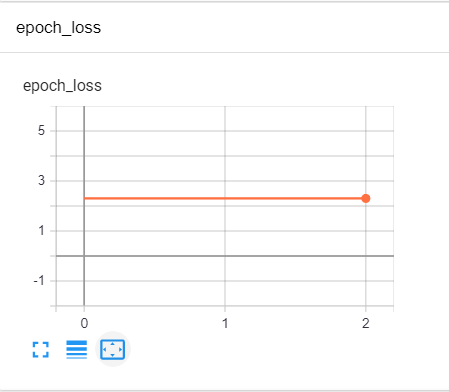

In [2]:
Image.open("model_1_2.png")

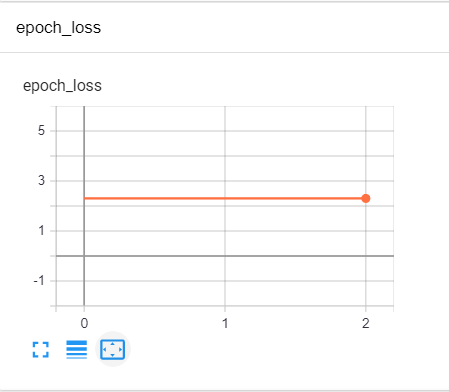

In [3]:
Image.open("model_1_3.png")

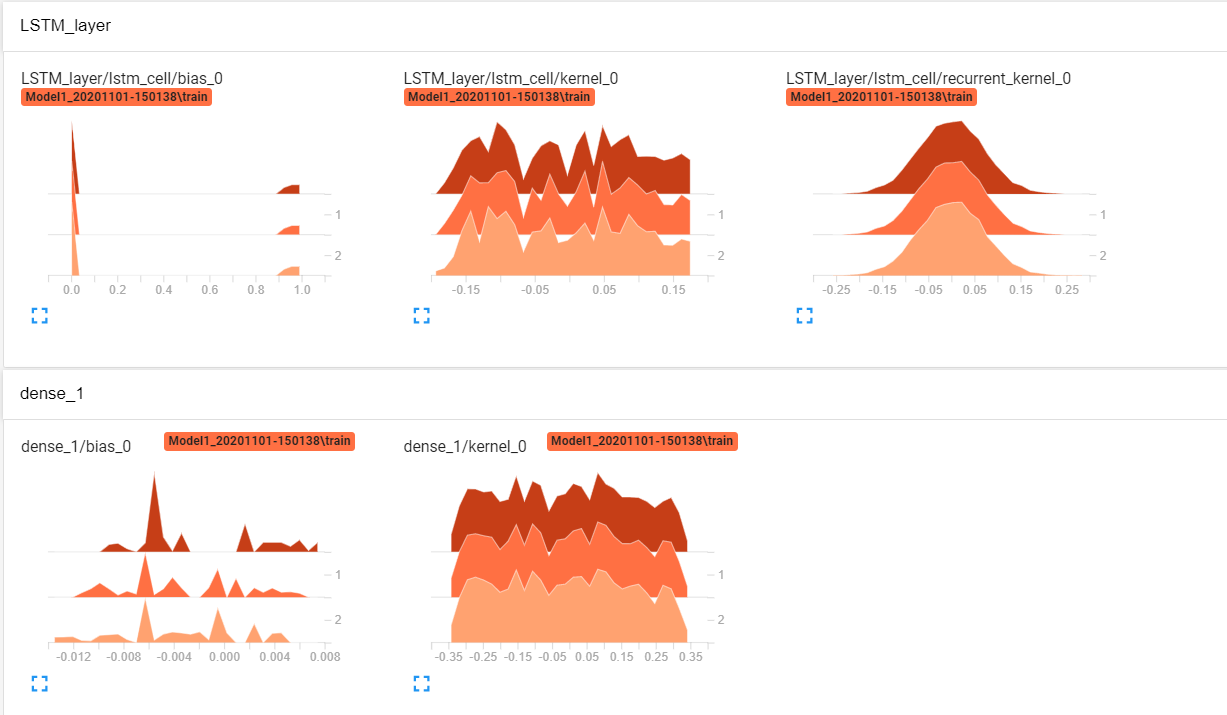

In [4]:
Image.open("model_1_4.png")

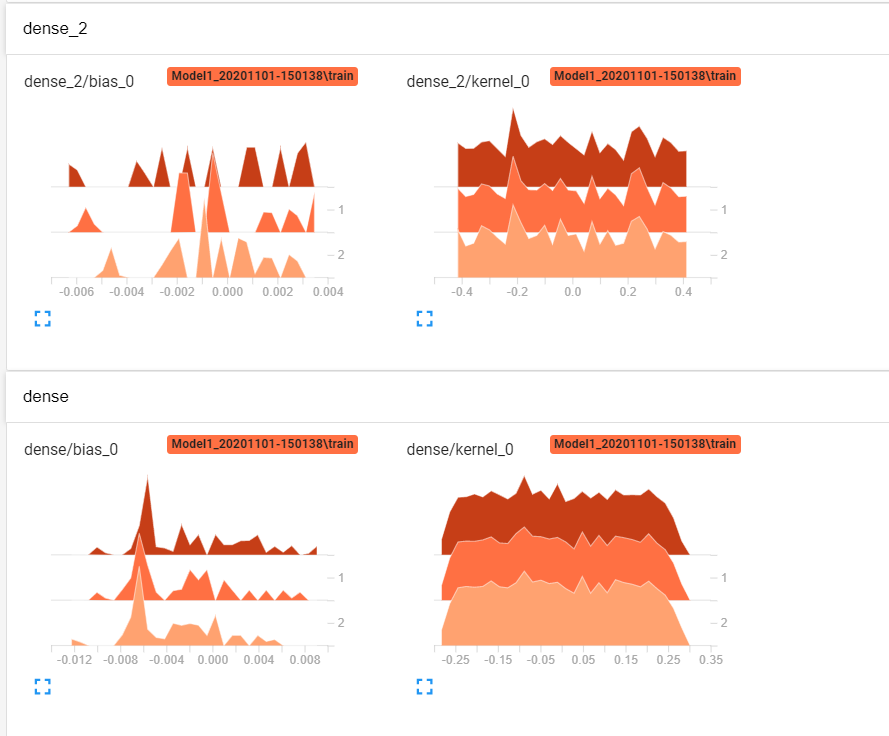

In [5]:
Image.open("model_1_5.png")

In [23]:
test_predictions = model.predict(x=[X_test_pad_seq,X_test_mask],batch_size=64,verbose=1)


10/10 [==============================] - 20s 2s/step


In [24]:
predictions=test_predictions.argmax(axis=1)
predictions = predictions.astype('int')

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=y_test.values.astype(int), y_pred=predictions))



Classification Report:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18        60
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        60
           6       0.00      0.00      0.00        60
           7       0.00      0.00      0.00        60
           8       0.00      0.00      0.00        60
           9       0.00      0.00      0.00        60

    accuracy                           0.10       600
   macro avg       0.01      0.10      0.02       600
weighted avg       0.01      0.10      0.02       600



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I have build the model for spoken digit recognition using the raw data and mask. After training model for 3 epoch , we can see that the model is predicting only one class only. When tried with different model architecture and dropout, the result is same. This might be happened due to the data(Raw Data) I used for the training. I have tested the again with Spectrogram Data as input in next model.

### 2. Converting into spectrogram and giving spectrogram data as input  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [11]:
sample_rate = 22050

In [12]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [13]:
def convert_dateset_toSpectogram(audioFiles):

  #logmel_spectrums=convert_to_spectrogram(audioFiles[0])
  logmel_spectrums=[]



  for i in range(len(audioFiles)):

    logmel_spectrum = convert_to_spectrogram(audioFiles[i])
    #print(logmel_spectrum.shape,type(logmel_spectrum))
    logmel_spectrums.append(logmel_spectrum)
    #print(logmel_spectrums)

  
  return  np.array(logmel_spectrums)

In [14]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram =  convert_dateset_toSpectogram(X_train_pad_seq)
X_test_spectrogram =  convert_dateset_toSpectogram(X_test_pad_seq)

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_processed,X_train_pad_seq, X_train_mask, X_train_spectrogram,y_train),open('/content/drive/My Drive/Colab Notebooks/Spoken/train_data_1.pkl','wb'))
pickle.dump((X_test, X_test_processed,X_test_pad_seq, X_test_mask,X_test_spectrogram,y_test),open('/content/drive/My Drive/Colab Notebooks/Spoken/test_data_1.pkl','wb'))

In [ ]:
X_train_spectrogram.shape


(1400, 64, 35)

<font size=4>Grader function 6 </font>

In [ ]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
5. make sure that it won't overfit. 
6. You are free to include any regularization
</pre>

In [26]:

input_layer1 = Input(shape=(64,35),name = 'input_layer',dtype='float32')

LSTM_layer = LSTM(512, return_sequences=True,name = 'LSTM_layer')(input_layer1)

LSTM_layer_1 = LSTM(256, return_sequences=True,name = 'LSTM_layer_1')(LSTM_layer)

Avg_Pooling_layer = GlobalAveragePooling1D()(LSTM_layer)

dense = Dense(256,activation='relu',name = 'dense')(Avg_Pooling_layer)


dense_1 = Dense(10, activation = 'softmax',name='dense_1')(dense)

#concat = concatenate([input_layer,input_mask])

model = Model(input_layer1,dense_1)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy',micro_f1])

In [27]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 35)]          0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 64, 512)           1122304   
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 1,256,202
Trainable params: 1,256,202
Non-trainable params: 0
_________________________________________________________________


In [28]:
import datetime
log_dir="/content/drive/My Drive/Colab Notebooks/Spoken/logs/Model2_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [29]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [30]:
y_train = y_train.astype('float64')

In [31]:
#train your model
model.fit(X_train_spectrogram, y_train, epochs=50, batch_size=64, callbacks=[tensorboard_callback])

Epoch 1/50
22/22 [==============================] - 23s 1s/step - loss: 2.1407 - accuracy: 0.2429 - micro_f1: 0.2427
Epoch 2/50
22/22 [==============================] - 22s 1s/step - loss: 1.8351 - accuracy: 0.3414 - micro_f1: 0.3409
Epoch 3/50
22/22 [==============================] - 22s 1s/step - loss: 1.6665 - accuracy: 0.4121 - micro_f1: 0.4122
Epoch 4/50
22/22 [==============================] - 22s 1s/step - loss: 1.4811 - accuracy: 0.5157 - micro_f1: 0.5159
Epoch 5/50
22/22 [==============================] - 22s 1s/step - loss: 1.3615 - accuracy: 0.5557 - micro_f1: 0.5555
Epoch 6/50
22/22 [==============================] - 22s 987ms/step - loss: 1.2791 - accuracy: 0.5679 - micro_f1: 0.5676
Epoch 7/50
22/22 [==============================] - 22s 987ms/step - loss: 1.1850 - accuracy: 0.6171 - micro_f1: 0.6174
Epoch 8/50
22/22 [==============================] - 22s 988ms/step - loss: 1.1293 - accuracy: 0.6264 - micro_f1: 0.6265
Epoch 9/50
22/22 [==============================] - 22s

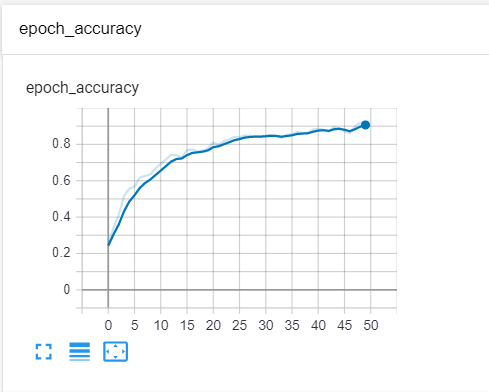

In [6]:
Image.open("model_2_1.png")

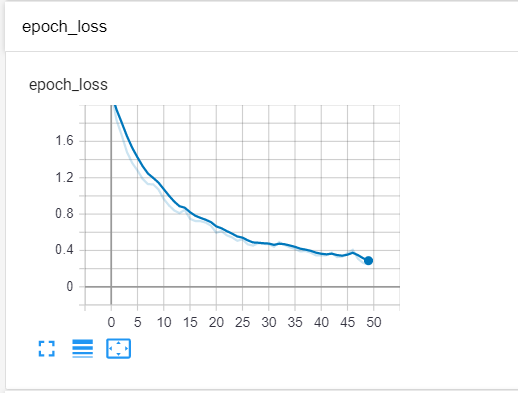

In [7]:
Image.open("model_2_2.png")

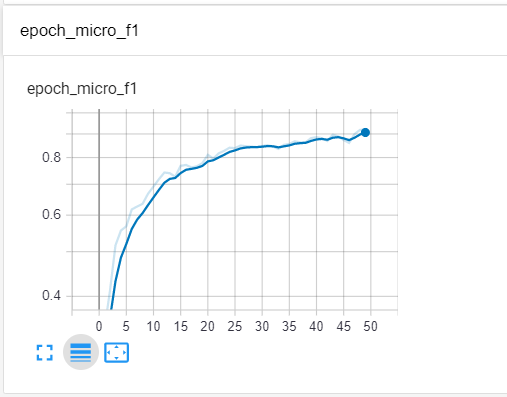

In [8]:
Image.open("model_2_3.png")

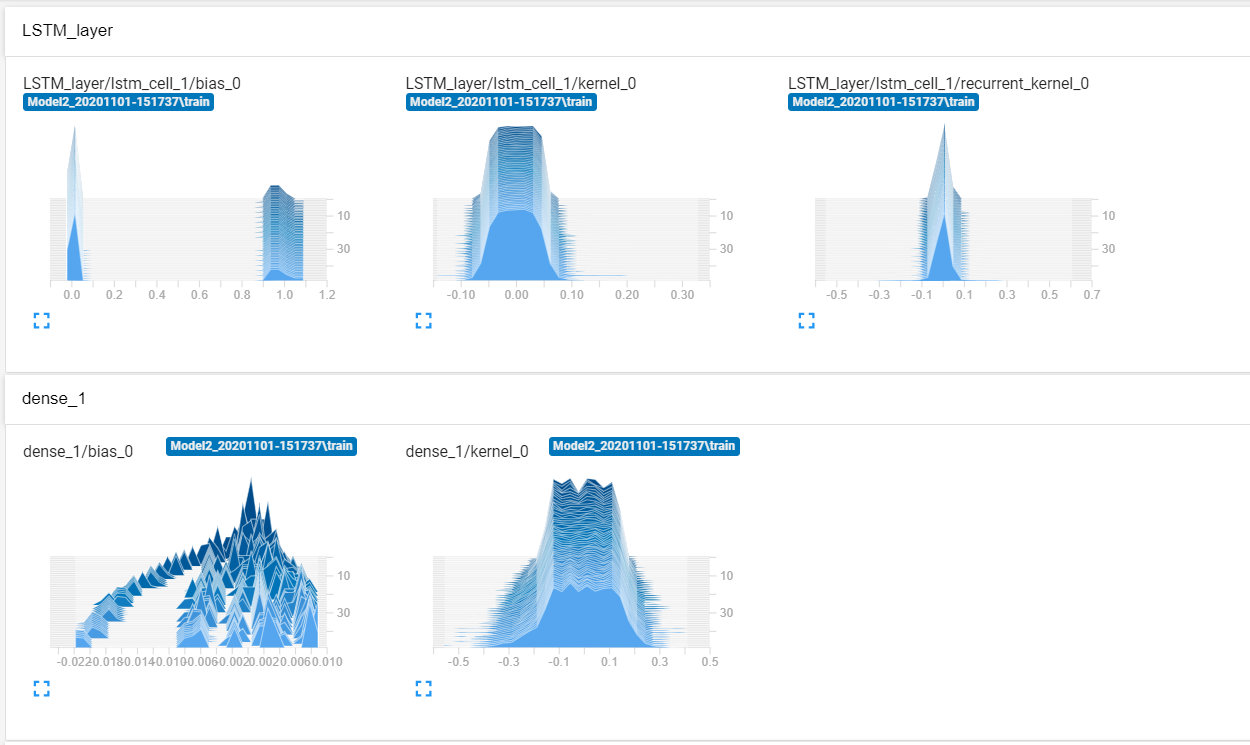

In [9]:
Image.open("model_2_4.png")

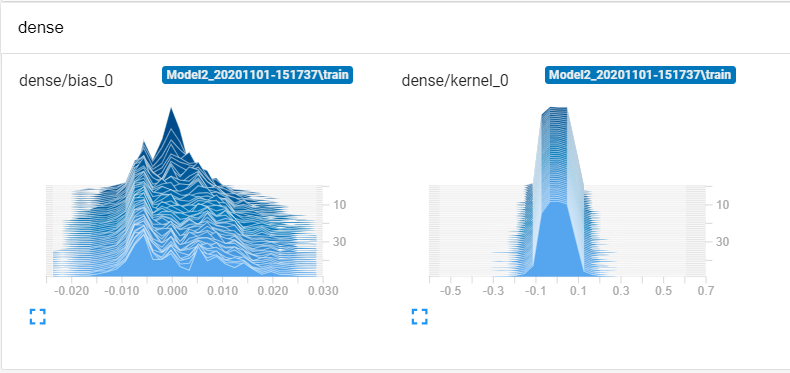

In [10]:
Image.open("model_2_5.png")

In [32]:
test_predictions = model.predict(x=X_test_spectrogram,batch_size=64,verbose=1)

10/10 [==============================] - 2s 192ms/step


In [34]:
predictions=test_predictions.argmax(axis=1)
predictions = predictions.astype('int')

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=y_test.values.astype(int), y_pred=predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        60
           1       0.89      0.90      0.89        60
           2       0.76      0.80      0.78        60
           3       0.74      0.65      0.69        60
           4       0.97      0.97      0.97        60
           5       0.91      0.87      0.89        60
           6       0.72      0.83      0.78        60
           7       0.77      0.93      0.84        60
           8       0.96      0.73      0.83        60
           9       0.95      0.95      0.95        60

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600



After building the model to handle the spectrogram as input data. I have trained the model with 50 epochs and can see the good result with this model. The f1 score for this model is more than 0.80 which is the good for the model. Looking at the above two model, I can say that spectrogram data is good for recognition as compair to raw data.

### 3. data augmentation  
<pre>
Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [ ]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [ ]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [ ]:
type(aug_temp[1])

numpy.ndarray

As discussed above, for one data point, we will get 9 augmented data points.  
We have 2000 data points(train plus test) so, after augmentation we will get 18000 ( train - 12600, test - 5400). 

do the above steps i.e training with raw data and spectrogram data with augmentation.

In [ ]:
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB


In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
y_train_df = pd.Series(y_train) 

In [ ]:
column_names = ["raw_data"]

X_train_augumented = pd.DataFrame(columns = column_names)
X_test_augumented = pd.DataFrame(columns = column_names)

column_names = ["label"]

y_train_augumented = pd.DataFrame(columns = column_names)
y_test_augumented = pd.DataFrame(columns = column_names)

In [ ]:
row_count=0

for i in range(len(X_train)):
  aug_temp = generate_augmented_data(X_train.iloc[i,0])

  for j in range(len(aug_temp)):
      X_train_augumented.loc[row_count]=[aug_temp[j]]
      y_train_augumented.loc[row_count]=y_train_df.iloc[i]
      row_count+=1
  


In [ ]:
X_train_augumented.shape

(12600, 1)

In [ ]:
y_train_augumented.shape

(12600, 1)

In [ ]:
y_test_df = pd.Series(y_test) 

In [ ]:
row_count=0

for i in range(len(X_test)):
  aug_temp = generate_augmented_data(X_test.iloc[i,0])

  for j in range(len(aug_temp)):
      X_test_augumented.loc[row_count]=[aug_temp[j]]
      y_test_augumented.loc[row_count]=y_test_df.iloc[i]
      row_count+=1
  


In [ ]:
X_test_augumented.shape

(5400, 1)

In [ ]:
print(type(X_train_augumented))
print(type(y_test_augumented))
print(type(X_test_augumented))
print(type(y_train_augumented))

print(type(X_train_processed))
print(type(X_test_processed))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_augumented, y_train_augumented,X_train_pad_seq_augumented,X_train_mask_augumented,X_train_spectrogram_augumented),open('/content/drive/My Drive/Colab Notebooks/Spoken/train_data_augumented.pkl','wb'))
pickle.dump((X_test_augumented, y_test_augumented,X_test_pad_seq_augumented,X_test_mask_augumented,X_test_spectrogram_augumented),open('/content/drive/My Drive/Colab Notebooks/Spoken/test_data_augumented.pkl','wb'))

In [15]:
X_train_augumented, y_train_augumented,X_train_pad_seq_augumented,X_train_mask_augumented,X_train_spectrogram_augumented = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Spoken/train_data_augumented.pkl', 'rb')) 
X_test_augumented, y_test_augumented,X_test_pad_seq_augumented,X_test_mask_augumented,X_test_spectrogram_augumented = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Spoken/test_data_augumented.pkl', 'rb')) 

#Model 3

In [ ]:
#all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.
(X_train_pad_seq_augumented, X_train_mask_augumented) =  convert_dateset(X_train_augumented)
(X_test_pad_seq_augumented, X_test_mask_augumented) =  convert_dateset(X_test_augumented)

In [36]:

input_layer1 = Input(shape=(17640,1),name = 'input_layer',dtype='float32')

input_layer2 = Input(shape=(17640,),name='input_mask',dtype='bool')

LSTM_layer = LSTM(50,return_sequences=False,name = 'LSTM_layer')(input_layer1,mask = input_layer2)

dense = Dense(32,activation='relu',name = 'dense')(LSTM_layer)

dense_1 = Dense(24,activation='relu',name = 'dense_1')(dense)

dense_2 = Dense(10, activation = 'softmax',name='dense_2')(dense_1)

#concat = concatenate([input_layer,input_mask])

model = Model([input_layer1, input_layer2],dense_2)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy',micro_f1])

In [37]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 17640)]      0                                            
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 50)           10400       input_layer[0][0]                
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           1632        LSTM_layer[0][0]      

In [38]:
import datetime
log_dir="/content/drive/My Drive/Colab Notebooks/Spoken/logs/Model3_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [39]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [40]:
y_train = y_train.astype('float64')

In [41]:
#train your model
model.fit([X_train_pad_seq_augumented,X_train_mask_augumented], y_train_augumented, epochs=3, batch_size=64, callbacks=[tensorboard_callback])

Epoch 1/3
197/197 [==============================] - 2693s 14s/step - loss: 2.3030 - accuracy: 0.0957 - micro_f1: 0.0957
Epoch 2/3
197/197 [==============================] - 2752s 14s/step - loss: 2.3028 - accuracy: 0.0955 - micro_f1: 0.0954
Epoch 3/3
197/197 [==============================] - 2729s 14s/step - loss: 2.3029 - accuracy: 0.0958 - micro_f1: 0.0958


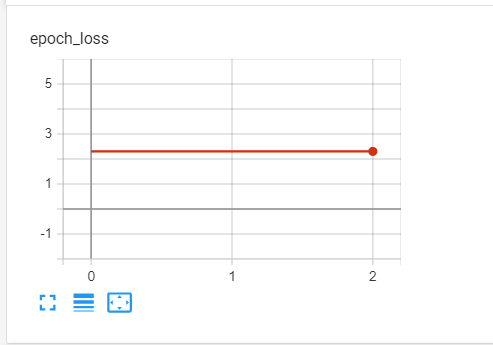

In [11]:
Image.open("model_3_1.png")

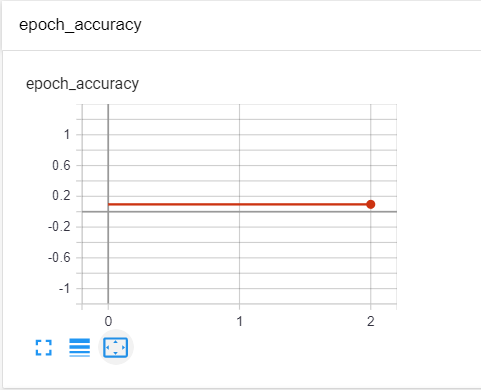

In [12]:
Image.open("model_3_2.png")

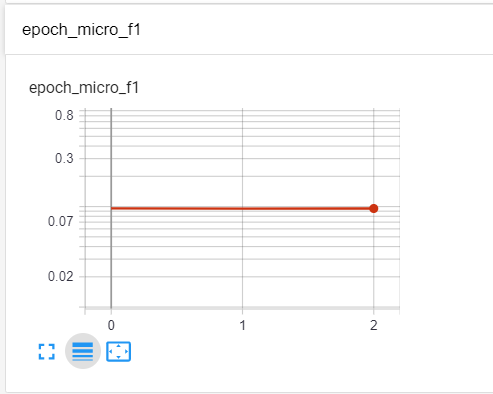

In [13]:
Image.open("model_3_3.png")

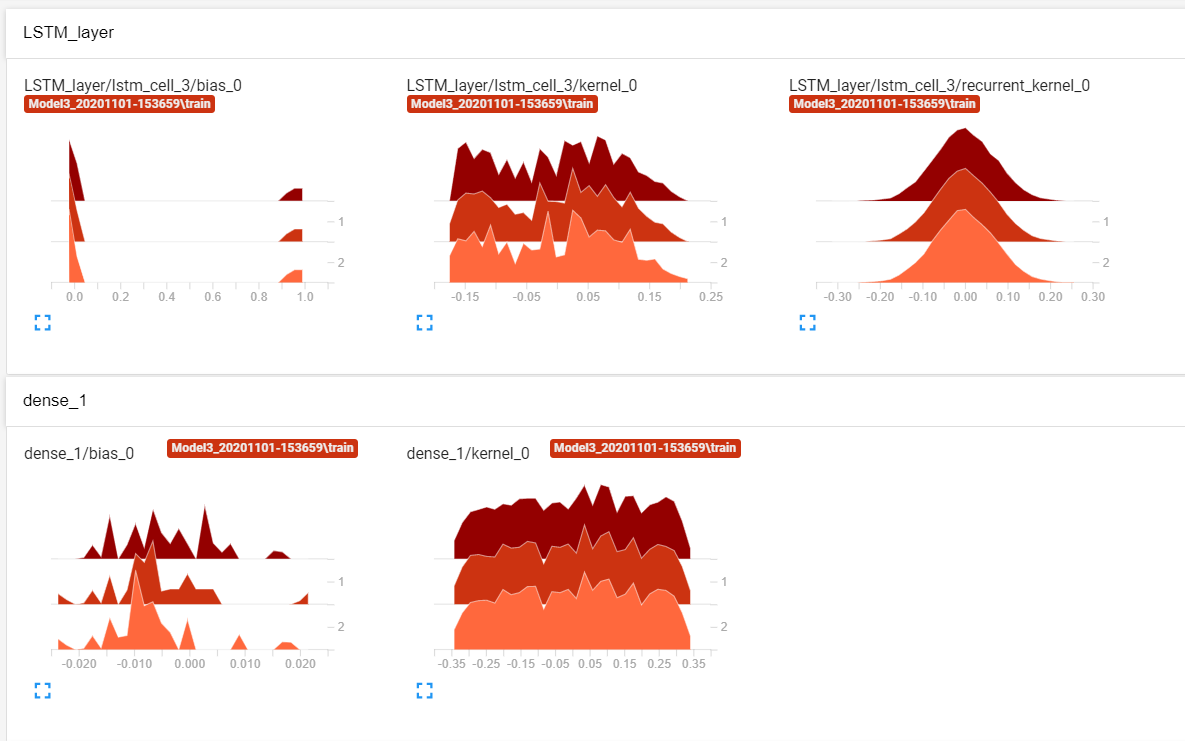

In [14]:
Image.open("model_3_4.png")

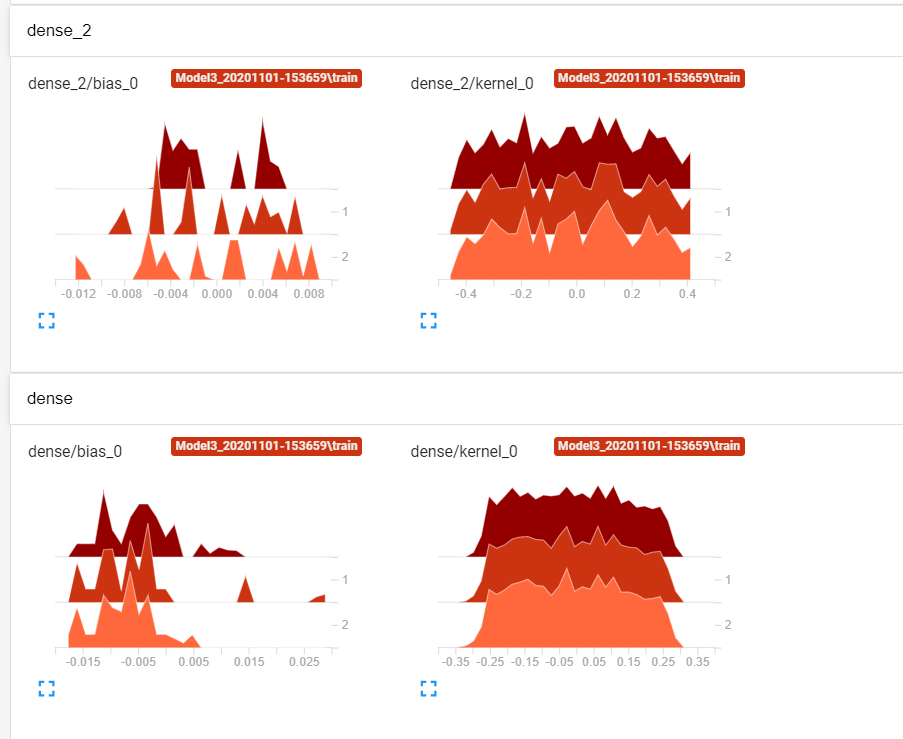

In [15]:
Image.open("model_3_5.png")

In [42]:
test_predictions = model.predict(x=[X_test_pad_seq_augumented,X_test_mask_augumented],batch_size=64,verbose=1)

85/85 [==============================] - 197s 2s/step


In [43]:

predictions=test_predictions.argmax(axis=1)
predictions = predictions.astype('int')

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=y_test_augumented.values.astype(int), y_pred=predictions))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       540
           1       0.10      1.00      0.18       540
           2       0.00      0.00      0.00       540
           3       0.00      0.00      0.00       540
           4       0.00      0.00      0.00       540
           5       0.00      0.00      0.00       540
           6       0.00      0.00      0.00       540
           7       0.00      0.00      0.00       540
           8       0.00      0.00      0.00       540
           9       0.00      0.00      0.00       540

    accuracy                           0.10      5400
   macro avg       0.01      0.10      0.02      5400
weighted avg       0.01      0.10      0.02      5400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I have build the model same as the model 1 for raw augumented data and masks as input. After training model for 3 epoch , I can see that the model is predicting one class only. The result is similar to what we have seen in model 1. The data augumentation hasn't help much in this model.

#Model 4

In [ ]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram_augumented =  convert_dateset_toSpectogram(X_train_pad_seq_augumented)
X_test_spectrogram_augumented =  convert_dateset_toSpectogram(X_test_pad_seq_augumented)

In [45]:

input_layer1 = Input(shape=(64,35),name = 'input_layer',dtype='float32')

LSTM_layer = LSTM(512, return_sequences=True,name = 'LSTM_layer')(input_layer1)

LSTM_layer_1 = LSTM(256, return_sequences=True,name = 'LSTM_layer_1')(LSTM_layer)

Avg_Pooling_layer = GlobalAveragePooling1D()(LSTM_layer)

dense = Dense(256,activation='relu',name = 'dense')(Avg_Pooling_layer)


dense_1 = Dense(10, activation = 'softmax',name='dense_1')(dense)

#concat = concatenate([input_layer,input_mask])

model = Model(input_layer1,dense_1)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy',micro_f1])

In [46]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 35)]          0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 64, 512)           1122304   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 1,256,202
Trainable params: 1,256,202
Non-trainable params: 0
_________________________________________________________________


In [47]:
import datetime
log_dir="/content/drive/My Drive/Colab Notebooks/Spoken/logs/Model4_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [48]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [49]:
y_train = y_train.astype('float64')

In [50]:
#train your model
model.fit(X_train_spectrogram_augumented, y_train_augumented, epochs=50, batch_size=64, callbacks=[tensorboard_callback])

Epoch 1/50
197/197 [==============================] - 203s 1s/step - loss: 1.7523 - accuracy: 0.3740 - micro_f1: 0.3741
Epoch 2/50
197/197 [==============================] - 205s 1s/step - loss: 1.1955 - accuracy: 0.5893 - micro_f1: 0.5893
Epoch 3/50
197/197 [==============================] - 204s 1s/step - loss: 0.9988 - accuracy: 0.6501 - micro_f1: 0.6501
Epoch 4/50
197/197 [==============================] - 203s 1s/step - loss: 0.8351 - accuracy: 0.7052 - micro_f1: 0.7052
Epoch 5/50
197/197 [==============================] - 206s 1s/step - loss: 0.7717 - accuracy: 0.7324 - micro_f1: 0.7324
Epoch 6/50
197/197 [==============================] - 203s 1s/step - loss: 0.6894 - accuracy: 0.7581 - micro_f1: 0.7582
Epoch 7/50
197/197 [==============================] - 207s 1s/step - loss: 0.6400 - accuracy: 0.7746 - micro_f1: 0.7746
Epoch 8/50
197/197 [==============================] - 203s 1s/step - loss: 0.6170 - accuracy: 0.7879 - micro_f1: 0.7879
Epoch 9/50
197/197 [====================

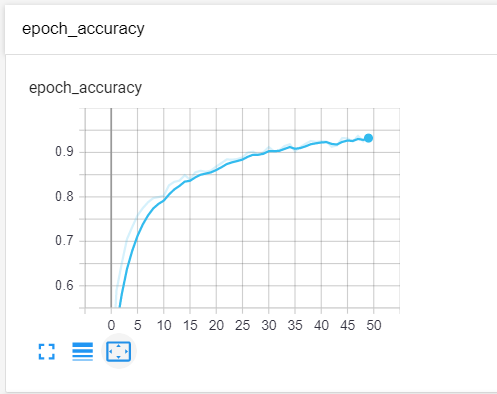

In [16]:
Image.open("model_4_1.png")

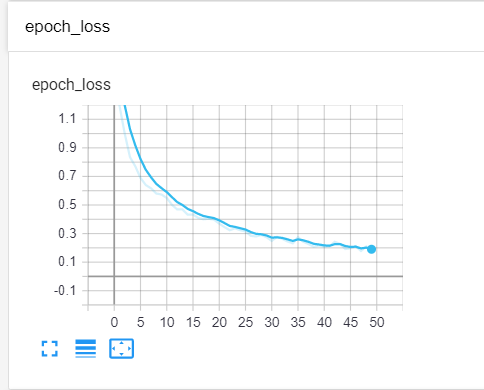

In [17]:
Image.open("model_4_2.png")

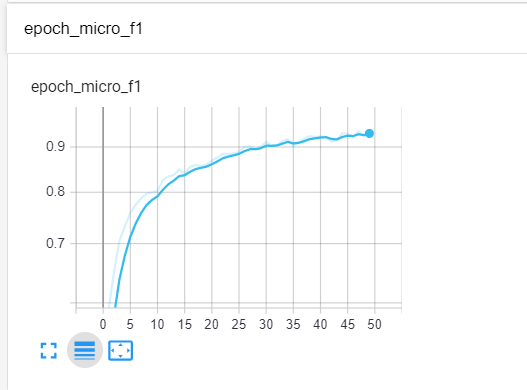

In [18]:
Image.open("model_4_3.png")

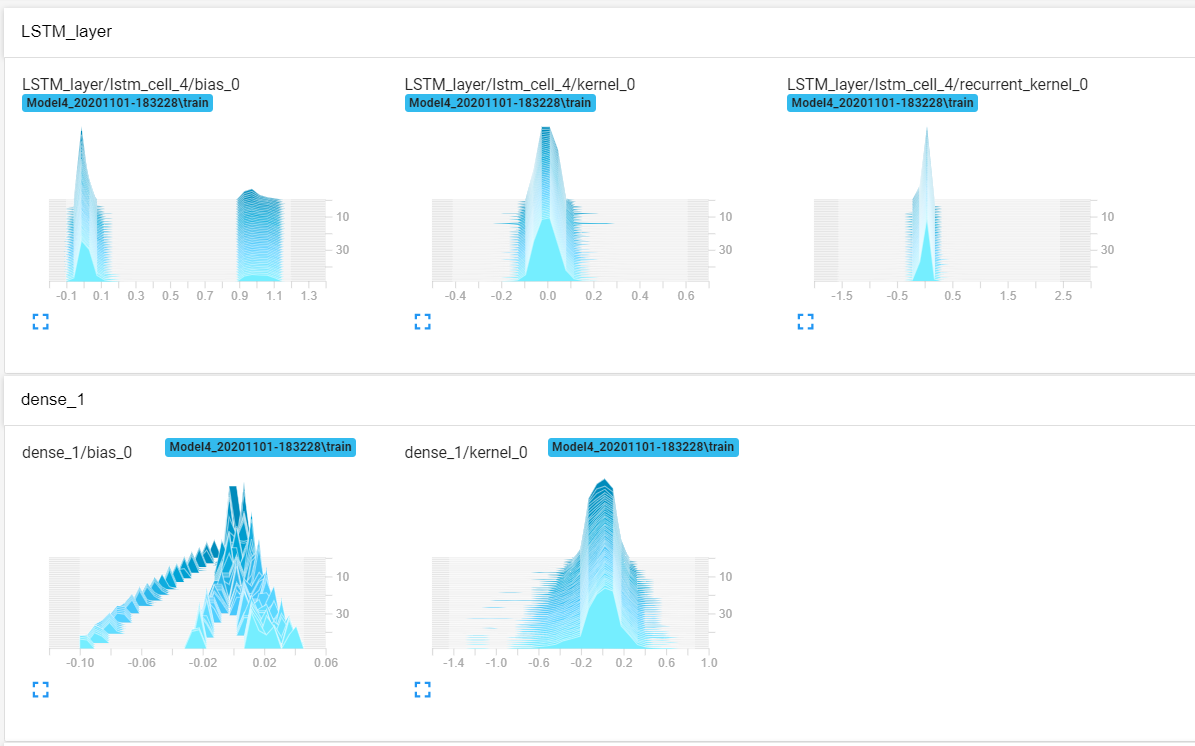

In [19]:
Image.open("model_4_4.png")

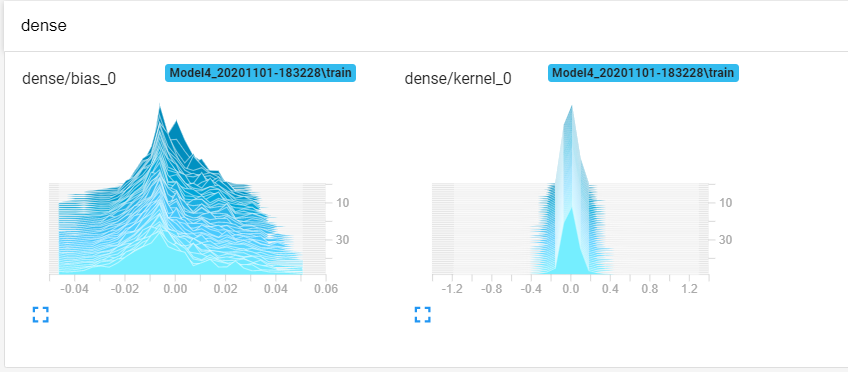

In [20]:
Image.open("model_4_5.png")

In [51]:
test_predictions = model.predict(x=X_test_spectrogram_augumented,batch_size=64,verbose=1)

85/85 [==============================] - 19s 222ms/step


In [52]:
predictions=test_predictions.argmax(axis=1)
predictions = predictions.astype('int')

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=y_test_augumented.values.astype(int), y_pred=predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       540
           1       0.92      0.94      0.93       540
           2       0.85      0.94      0.89       540
           3       0.85      0.74      0.79       540
           4       0.97      0.93      0.95       540
           5       0.96      0.82      0.89       540
           6       0.77      0.88      0.82       540
           7       0.87      0.88      0.87       540
           8       0.92      0.89      0.91       540
           9       0.91      0.97      0.94       540

    accuracy                           0.90      5400
   macro avg       0.90      0.90      0.90      5400
weighted avg       0.90      0.90      0.90      5400



I have build the model same as the model 2 for augumented spectrogram data as input. After training model for 50 epoch , I can see that the model is predicting all the class. Looking at the result of all 4 Models, we can say that spectrogram data is really helpful for recognition of the spoken digit.